<div>
<img src="https://notebooks.dtcglaciers.org/_images/ESA_logo.svg" width="160" align='right'/>
</div>

# A DTC-Glaciers example for hydropower outlook

In this notebook, we show how the plots used in the Dea User Story **[“A glacier digital twin component to inform hydropower outlook”](https://dea.destine.eu/web/stories/viewer/684039a1b62b202b54ee0271)** can be recreated.

## The user story

The user story focuses on the **summer of 2015**, when Iceland faced a major challenge for its hydropower system. During this period, glacier runoff was exceptionally low, leading to serious concerns about electricity production. We use the tools provided by **DTC-Glaciers** to explore how a **glacier digital twin** can help to better understand, anticipate, and manage such events in the future.

### Hydropower and glaciers in Iceland

More than **80% of Iceland’s electricity** is generated from **hydropower**. These power plants have been historically developed and operated by **[Landsvirkjun](https://en.wikipedia.org/wiki/Landsvirkjun)**, Iceland’s national power company, and they play a key role in the country’s low-carbon energy system.

The **[Kárahnjúkar Hydropower Plant](https://en.wikipedia.org/wiki/K%C3%A1rahnj%C3%BAkar_Hydropower_Plant)** is the largest hydropower plant in Iceland, with an annual production of around **4,600 GWh**. It is supplied by a catchment area of **1,660 km²**, of which **72% is covered by glacier ice**. Most of this ice belongs to **Brúarjökull**, an outlet glacier of **[Vatnajökull](https://en.wikipedia.org/wiki/Vatnaj%C3%B6kull)**, the largest ice cap in Iceland.

### The summer of 2015 was highly unusual

**Cold weather** and **persistent cloud cover** led to a much **later** and **weaker melt season** than normal. As a result, glacier runoff was strongly reduced. According to Landsvirkjun, this was **one of the worst melt seasons** ever observed for their reservoirs (Source: [International Water Power Magazine](https://www.waterpowermagazine.com/analysis/managing-hydro-operations-in-iceland-4831665/)).

By **August, river flow rates** were still **very low**. This raised serious **concerns** about **electricity supply** and even led to **discussions about emergency measures** for the coming winter. In the end, heavy precipitation later in the summer refilled the reservoirs, and power rationing could be avoided.

**This event clearly shows the need for better preparedness.**

### Why this matters for the future

While the summer of 2015 was exceptional, **similar conditions** can **occur again**. Years with **positive glacier mass balance** can reduce meltwater availability and create comparable **challenges for hydropower production**.

In this notebook, we treat the year **2015 as a hindcast**. This means we use it as a real-world test case to evaluate how well future forecasts might perform under similar conditions.

**Can an Earth-observation-informed Glacier Digital Twin help us anticipate such critical situations before they happen?**

## What observations tell us about 2015

If required, install the DTCG API using the following command:

```
!pip install 'dtcg[jupyter] @ git+https://github.com/DTC-Glaciers/dtcg'
```

Run this command in a notebook cell.

In [1]:
# Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.legend_handler import HandlerTuple

from oggm.core import massbalance
from oggm import utils

import dtcg.integration.oggm_bindings as oggm_bindings
import dtcg.integration.calibration as calibration
from dtcg import DEFAULT_L2_DATACUBE_URL
from dtcg.datacube.geozarr import GeoZarrHandler
from dtcg.validation.validator import DatacubeValidator
from dtcg.validation.cryosat_validation import get_cryosat_data

We start by exploring the data available in the **preprocessed DTC-Glaciers L1 datacubes**. The workflow used to create these L1 datacubes is described in more detail in the notebook [Creating DTC-Glaciers EO-Native Data Cubes (L1)](01_L1_datacubes.ipynb).

For this example, we open the preprocessed datacubes for **Brúarjökull** and examine the available observations.

In particular, this section focuses on:
- **In-situ glacier mass balance measurements** provided by the **[WGMS](https://wgms.ch/)**  
- **Surface elevation change maps** from **[CryoTEMPO-EOLIS](https://cryotempo-eolis.org/)**, derived from **CryoSat-2** observations


In [2]:
# Define the glacier we want to analyse and open the preprocessed DTC-Glaciers data
rgi_id_ice = "RGI60-06.00377"  # Brúarjökull
dtcg_oggm_ice = oggm_bindings.BindingsOggmModel(rgi_id=rgi_id_ice)

def get_l2_data_tree(rgi_id):
    return xr.open_datatree(
            f"{DEFAULT_L2_DATACUBE_URL}{rgi_id}.zarr",
            chunks={},
            engine="zarr",
            consolidated=True,
            decode_cf=True,
        )

data_tree_ice = get_l2_data_tree(rgi_id_ice)
l1_datacube_ice = data_tree_ice['L1'].ds

### In-situ mass balance observations from WGMS

The figure below shows the WGMS observations from the last 25 years:

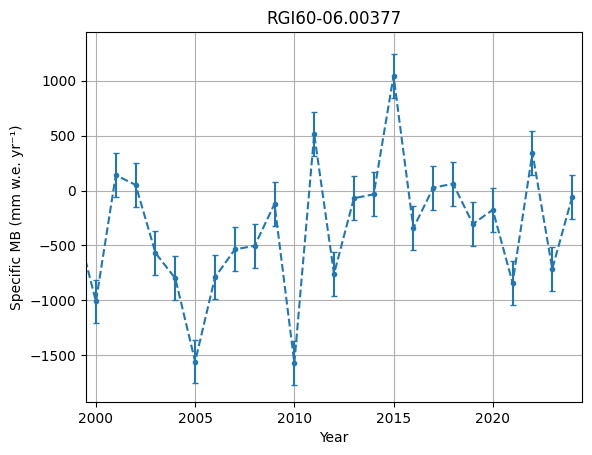

In [3]:
plt.errorbar(x=l1_datacube_ice.t_wgms,
             y=l1_datacube_ice.wgms_mb,
             yerr=l1_datacube_ice.wgms_mb_unc,
             fmt=".--", capsize=2)
plt.grid("on")
plt.ylabel("Specific MB (mm w.e. yr⁻¹)")
plt.xlabel("Year")
plt.title(dtcg_oggm_ice.l1_datacube.attrs["RGI-ID"])
plt.xlim([1999.5, 2024.5])
plt.show()

From the plot above, we see that **2015 had the most positive glacier mass balance of the last 25 years**.

In [4]:
# Calculate statistics
print("Mean annual mass balance 2000 to 2025: "
      f"{l1_datacube_ice.wgms_mb.sel(t_wgms=slice(2000, 2025)).mean().values:.0f} mm w.e. yr⁻¹")
print("             Annual mass balance 2015: "
      f"{l1_datacube_ice.wgms_mb.sel(t_wgms=2015).mean().values:.0f} mm w.e. yr⁻¹")

Mean annual mass balance 2000 to 2025: -343 mm w.e. yr⁻¹
             Annual mass balance 2015: 1044 mm w.e. yr⁻¹


The observed mass balance in **2015** was **1044 mm w.e. yr⁻¹**, compared to a **25-year mean** of **−343 mm w.e. yr⁻¹**. This large difference clearly shows how **exceptional the year 2015** was.

### CryoTEMPO-EOLIS elevation changes from CryoSat-2

The exceptional nature of **2015** is also visible in the **CryoTEMPO-EOLIS** surface elevation change maps.  

Below, we compare the **annual glacier elevation change** in **2015** with the **multi-year average**:

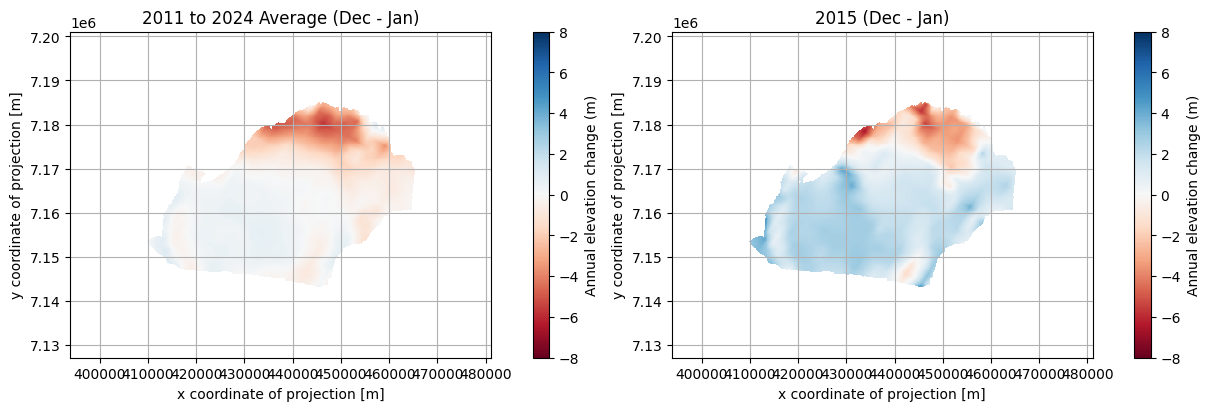

In [5]:
da = l1_datacube_ice.eolis_gridded_elevation_change.load()

# Calculate per-pixel difference between December and January for each year
jan = da.sel(t=da['t'].dt.month == 1).groupby('t.year').mean('t')
dec = da.sel(t=da['t'].dt.month == 12).groupby('t.year').mean('t')
annual_diff = dec - jan                     # dims: ('year', 'y', 'x')

# Average across years to get the per-pixel mean annual difference
avg_annual_diff = annual_diff.mean('year', skipna=True)

# Pull out 2015 specifically
annual_diff_2015 = annual_diff.sel(year=2015)

# plot
cmap = "RdBu"
vmin = -8
vmax = 8
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
avg_annual_diff.plot(ax=axes[0], robust=True, cmap=cmap, vmin=vmin, vmax=vmax, cbar_kwargs={"label": "Annual elevation change (m)"})
annual_diff_2015.plot(ax=axes[1], robust=True, cmap=cmap, vmin=vmin, vmax=vmax, cbar_kwargs={"label": "Annual elevation change (m)"})

axes[0].set_title(f'{annual_diff.year.values.min()} to {annual_diff.year.values.max()} Average (Dec - Jan)')
axes[1].set_title('2015 (Dec - Jan)')
axes[0].grid('on')
axes[1].grid('on')
plt.show()

When comparing the **2015 map** with the **14-year average**, we see much more **positive elevation change** (shown in blue). This indicates that **glacier mass gain was significantly higher in 2015** than in an average year.

In the **[Dea user story](https://dea.destine.eu/web/stories/viewer/684039a1b62b202b54ee0271)**, additional maps of **surface albedo** are shown. These data are not yet included in the DTC-Glaciers L1 datacubes. The albedo observations also show **higher values in 2015** compared to an average year, which points to **increased snow accumulation**.

A **high albedo** means that more sunlight is reflected, which typically indicates the presence of **snow rather than bare ice**.


## Out-of-the-box output from DTC-Glaciers

We now take a look at what **DTC-Glaciers** tells us about **2015** using an **out-of-the-box configuration**.
More detailed information on how this configuration was created can be found in the notebook [Creating DTC-Glaciers EO-DT-Enhanced Data Cubes (L2)](02_L2_datacubes.ipynb).

Under the hood, DTC-Glaciers is based on the **[Open Global Glacier Model (OGGM)](https://oggm.org/)**. Here, *out-of-the-box* refers to a model setup in which OGGM is **calibrated using CryoSat-2 data from 2011 to 2020**.

The model output from this calibration is already included in the **preprocessed DTC-Glaciers datacubes**, allowing us to inspect the results directly without running any additional computations.

In [6]:
# Define the name of the L2 datacube we want to analyse
L2_name = 'L2_Daily_Cryosat_2011_2020'

In [7]:
# function for preparing the data for the plot
def get_elevation_change_per_year(data_tree, L2_name, start_month=10):
    # get data from data_tree
    da_smb = data_tree[L2_name]['daily_smb'].specific_mb.copy()

    # convert float year to datetime
    yrs, mnths, dys = utils.floatyear_to_date(da_smb.time,
                                              return_day=True)
    smb_dates = np.array([f"{y:04d}-{m:02d}-{d:02d}"
                          for y, m, d in zip(yrs, mnths, dys)],
                         dtype="datetime64[D]")
    da_smb['time'] = smb_dates

    # add hydro coordinate and day of year
    da_smb = da_smb.drop_vars('calendar_year')
    hydro_year = xr.where(
        da_smb.time.dt.month >= start_month,
        da_smb.time.dt.year + 1,
        da_smb.time.dt.year,
    )
    # hydrological year start
    hydro_start = xr.DataArray(
        (hydro_year - 1).astype(int).astype(str) + f"-{start_month:02d}-01",
        dims="time",
    ).astype("datetime64[ns]")
    
    # hydrological day index (Oct 1 = 1)
    hydro_doy = ((da_smb.time - hydro_start) / np.timedelta64(1, "D")).astype(int) + 1
    da_h = da_smb.assign_coords(hydro_year=("time", hydro_year.values),
                                hydro_doy=("time", hydro_doy.values))
    
    # cumsum per hydro_year, reset to 0
    g = da_h.groupby("hydro_year")
    da_cumsum = g.cumsum("time") - g.cumsum("time").isel(time=0)
    
    # reshape to (hydro_year, hydro_doy) (requires unique hydro_doy within a year)
    da_overlay = (
        da_cumsum
        .assign_coords(hydro_year=("time", hydro_year.values),
                       hydro_doy=("time", hydro_doy.values))
        .set_index(time=["hydro_year", "hydro_doy"])
        .unstack("time")
        .sortby("hydro_doy")
    ) / 850

    return da_overlay

In [8]:
def plot_annual_elevation_change(
    data_tree,
    L2_name,
    L2_name_reinformed=None,
    annual_range=[2000, 2025],
    special_year=2015,
    add_special_year_uncertainty=False,
    add_observation=False,
    add_observation_used_for_calibration=False,
    label_oggm_default='OGGM average and range of medians: Oct {} - Sep {}',
    label_oggm_special_year='OGGM: Oct {} - Sep {} (median',
    label_cryosat='CryoSat-2 starting Oct {}',
    label_reinformed='OGGM reinformed by CryoSat-2 from Jun 2015',
    c_special_year='red',
    c_obs='C0',
    c_reinformed='C1',
    ylim=None,
    lw=2,
    ms=10,
    dpi=200,
    fontsize=13,
):
    # prepare data for plotting and select annual_range
    da_hydro_elev = get_elevation_change_per_year(
        data_tree=data_tree, L2_name=L2_name)

    plt.rcParams.update({'font.size': fontsize})

    legend_handles = []
    legend_labels = []

    # actual plotting
    fig, ax = plt.subplots(1, 1, figsize=(8.5, 5.5), dpi=dpi)

    # use the same value for x for all
    date_index = pd.date_range(start=f'2014-10-01', end=f'2015-10-01', freq='D')

    # plot the mean and range of all years
    if annual_range:
        da_hydro_elev = da_hydro_elev.sel(
        hydro_year=slice(annual_range[0], annual_range[1]))
        line, = ax.plot(
            date_index,
            da_hydro_elev.sel(member='0.5').mean(dim='hydro_year'),
            'k',
           )
        band = ax.fill_between(
            date_index,
            da_hydro_elev.sel(member='0.5').min(dim='hydro_year'),
            da_hydro_elev.sel(member='0.5').max(dim='hydro_year'),
            color='k',
            alpha=0.2,
           )

        legend_handles.append((line, band))
        legend_labels.append(label_oggm_default.format(annual_range[0], annual_range[1]))
    
    # add special_year curve
    line, = ax.plot(
        date_index,
        da_hydro_elev.sel(member='0.5', hydro_year=special_year),
        c=c_special_year,
    )
    if add_special_year_uncertainty:
        band = ax.fill_between(
            date_index,
            da_hydro_elev.sel(member='0.15', hydro_year=special_year),
            da_hydro_elev.sel(member='0.85', hydro_year=special_year),
            color=c_special_year,
            alpha=0.2,
        )
        legend_handles.append((line, band))
        legend_labels.append(label_oggm_special_year.format(special_year - 1, special_year) + ' and uncertainty)')
    else:
        legend_handles.append(line)
        legend_labels.append(label_oggm_special_year.format(special_year - 1, special_year) + ')')

    # add results from reinformed L2 datacube
    if L2_name_reinformed is not None:
        da_hydro_elev_reinform = get_elevation_change_per_year(
            data_tree=data_tree, L2_name=L2_name_reinformed)
        line, = ax.plot(
            date_index,
            da_hydro_elev_reinform.sel(member='0.5', hydro_year=special_year),
            c=c_reinformed)
        band = ax.fill_between(
            date_index,
            da_hydro_elev_reinform.sel(member='0.25', hydro_year=special_year),
            da_hydro_elev_reinform.sel(member='0.75', hydro_year=special_year),
            color=c_reinformed, alpha=0.2)
        legend_handles.append((line, band))
        legend_labels.append(label_reinformed)

    # add observation
    if add_observation:
        baseline_date = f'{special_year - 1}-10-01'
        cryosat_elev, cryosat_elev_unc = get_cryosat_data(
            l1_datacube=data_tree['L1'], baseline_date=baseline_date)
        err = ax.errorbar(
            data_tree['L1'].t.astype('datetime64[D]'),
            cryosat_elev,
            yerr=cryosat_elev_unc,
            fmt='o--', c=c_obs,
            lw=lw, ms=ms)
        legend_handles.append(err)
        legend_labels.append(label_cryosat.format(special_year - 1))

        if add_observation_used_for_calibration:
            calibration_date = np.array(add_observation_used_for_calibration, dtype="datetime64[ns]")
            ax.errorbar(cryosat_elev.sel(t=calibration_date, method='nearest').t.astype('datetime64[D]'),
                        cryosat_elev.sel(t=calibration_date, method='nearest'),
                        yerr=cryosat_elev_unc.sel(t=calibration_date, method='nearest'),
                        fmt='o', c=c_reinformed,
                        lw=lw, ms=ms)
    
    # format x-axis
    ax.set_xlim([date_index[0], date_index[-2]])
    import matplotlib.dates as mdates
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    import matplotlib.ticker as ticker
    plt.gca().xaxis.set_minor_locator(ticker.NullLocator())

    # format y-axis
    ax.set_ylabel('Elevation change in m')
    ax.set_ylim(ylim)
    
    ax.legend(legend_handles, legend_labels,
              handler_map={tuple: HandlerTuple()},
              loc='lower center')
    ax.grid('on')
    
    plt.show()

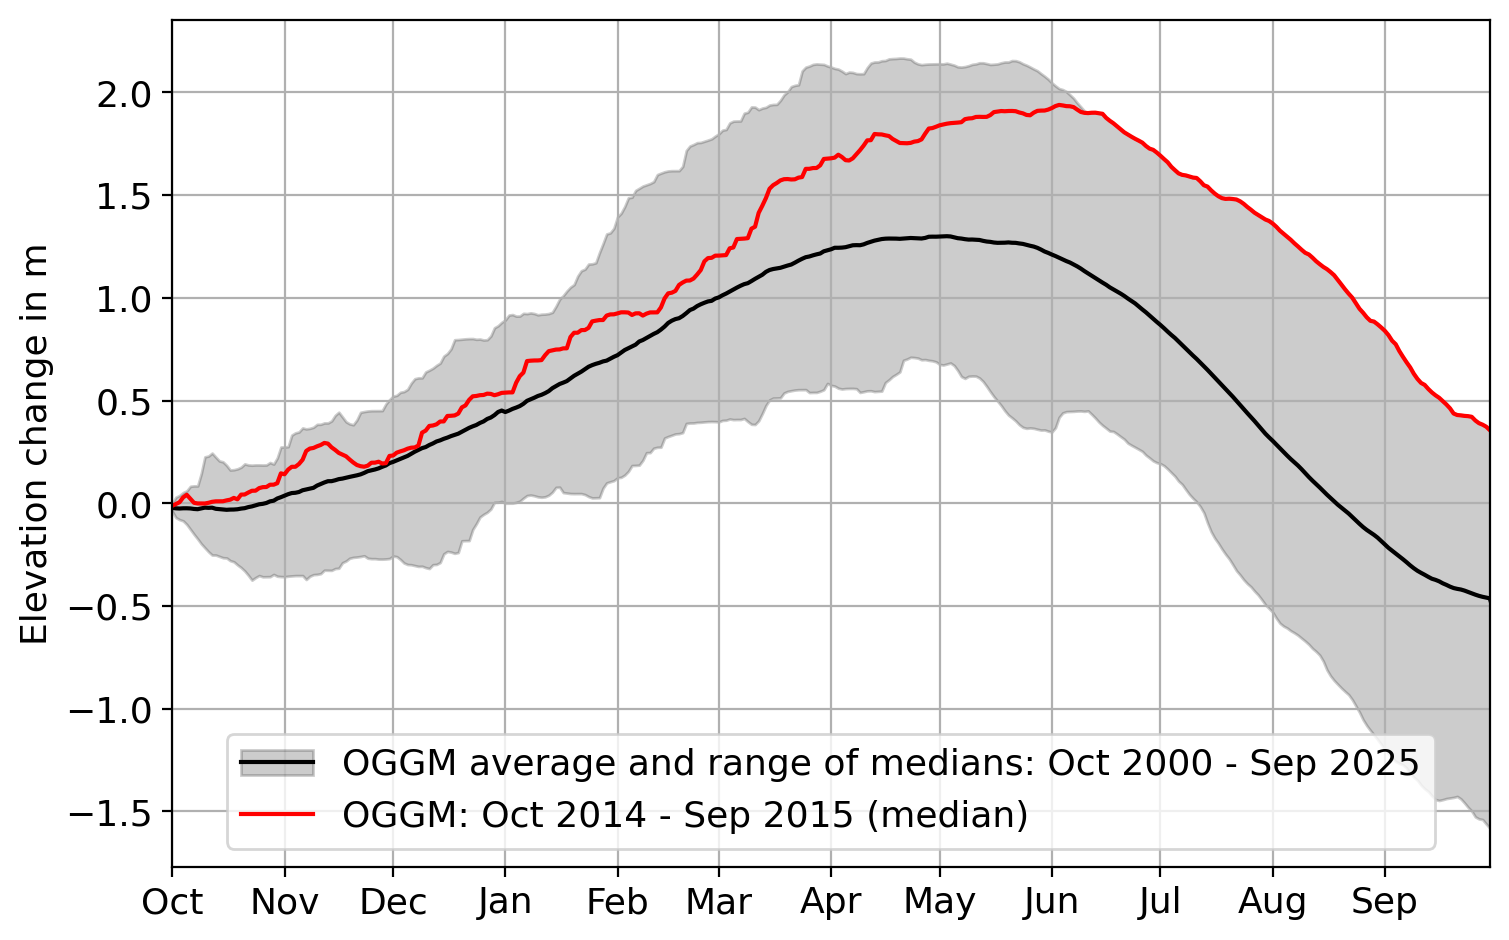

In [9]:
plot_annual_elevation_change(
    data_tree=data_tree_ice,
    L2_name=L2_name,
    annual_range=[2000, 2025],
    special_year=2015,)

This graph shows **daily output** from the standard OGGM glacier mass balance model, calibrated using **multi-year averages of CryoSat-2 surface elevation change observations**.

The **black line** represents the **average hydrological year** over the period **2000–2025**. It shows snow accumulation until late May, followed by a short but intense melt season. The shaded area indicates the **year-to-year variability**, highlighting how different individual seasons can be.

The **red line** shows the modeled evolution during the **2014–2015 hydrological year**. This year clearly stands out: summer melting did not begin until **mid-June**, and the year ended as the **most positive mass balance year of the entire 25-year period**.

Next, we compare the **model output for 2015** with the **glacier-integrated CryoSat-2 observations** from the same year:

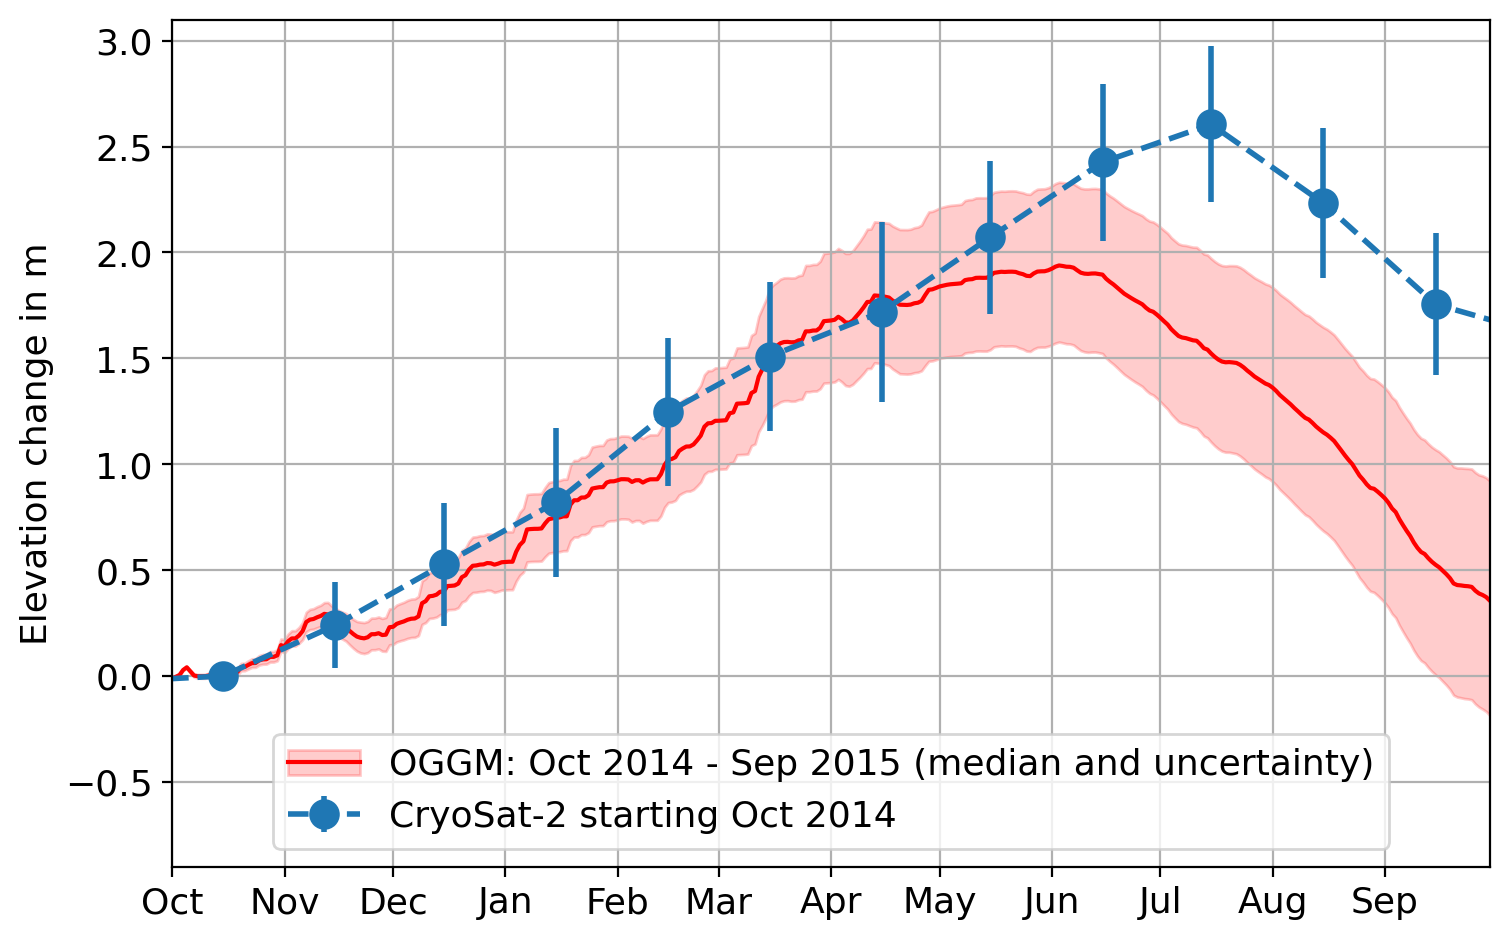

In [10]:
plot_annual_elevation_change(
    data_tree=data_tree_ice,
    L2_name=L2_name,
    annual_range=None,
    special_year=2015,
    add_special_year_uncertainty=True,
    add_observation=True,
    ylim=[-0.9, 3.1],
)

We see that the model and the observations agree quite well until **mid-May**. However, from **June onwards** the model no longer follows the measurements. As the exceptional summer of 2015 unfolds, the standard out-of-the-box setup is not able to capture the observed evolution.

**From the perspective of an operator in June: would the delayed onset of melt have been enough to trigger early action - and could the model have been trusted at that point?**

Next, we revisit 2015, but this time we **incorporate CryoSat-2 information as the season progresses**. In practice, this means we use the **mid-June CryoSat-2 observation** to update (reinform) the DTC-Glaciers model state.

## Calibrate DTC-Glaciers with CryoSat-2 observations from June 2015

The tools used below to reinform **DTC-Glaciers** are described in more detail in the notebook [Creating DTC-Glaciers EO-DT-Enhanced Data Cubes (L2)](02_L2_datacubes.ipynb).

In principle, we only need to define the **reference period** used for the calibration. In this example, the period runs from **1 October 2014 to 1 June 2015**. Internally, DTC-Glaciers automatically searches for the **closest available CryoSat-2 observations** to these dates.

We then run the DTC-Glaciers calibration workflow and **add the resulting model output** to the existing `data_tree` for later analysis.

The calibration below takes **around three minutes** to complete. If you want to reduce computing time, you can set `nr_samples` to a smaller value. This reduces the **ensemble size of the Monte Carlo simulation** used for uncertainty propagation (explained in more detail in [this notebook](02_L2_datacubes.ipynb#data-assimilation-and-error-propagation-with-monte-carlo-simulation)).

In [11]:
# Define a descriptive name for the updated DTC-Glaciers configuration
L2_name_reinformed = 'L2_Daily_Cryosat_2015_Jun'

# Initialise the calibrator, define the settings, and run the calibration
calibrator = calibration.CalibratorCryotempo(l1_datacube=data_tree_ice['L1'].ds,
                                             gdir=dtcg_oggm_ice.gdir)

calibrator.set_model_matrix(
    name=L2_name_reinformed,
    model=massbalance.DailyTIModel,
    ref_mb_period="2014-10-01_2015-06-01",
    source="CryoTEMPO-EOLIS",
    extra_kwargs={},
)

l2_datacubes = calibrator.calibrate(
    gdir=dtcg_oggm_ice.gdir,
    # Show log messages during the workflow to monitor progress
    show_log=True,
    # 'nr_samples' defines the ensemble size for the Monte Carlo simulation.
    # To reduce computing time, this can be set to 2**3 or 2**2.
    mcs_sampling_settings={'nr_samples': 2**4,},
    # Select the output data to generate; here we request all available outputs
    datacubes_requested=['monthly', 'annual_hydro', 'daily_smb'],
)

# Add the new L2 datacube to the existing data_tree
datacube_handler = GeoZarrHandler(data_tree=data_tree_ice)
datacube_handler.add_layer(datacubes=l2_datacubes[L2_name_reinformed],
                           datacube_name=L2_name_reinformed)

  0%|                                                                                                       | 0/1 [00:00<?, ?it/s]

L2_Daily_Cryosat_2015_Jun_2014-10-01_2015-06-01:
  Starting Monte Carlo Simulation for 96 ensemble members.
  Finished Monte Carlo Simulation: 96 ensemble members for output aggregation available.
  Start generating datacubes
    Start generation of monthly datacube
    Finished generation of monthly datacube
    Start generation of annual_hydro datacube
    Finished generation of annual_hydro datacube
    Start generation of daily_smb datacube


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:47<00:00, 227.67s/it]

    Finished generation of daily_smb datacube
  Finished generating datacubes



## Reinformed vs. out-of-the-box DTC-Glaciers output

Below, we compare the **reinformed DTC-Glaciers output** with the **out-of-the-box results** and the **glacier-integrated CryoSat-2 observations**:

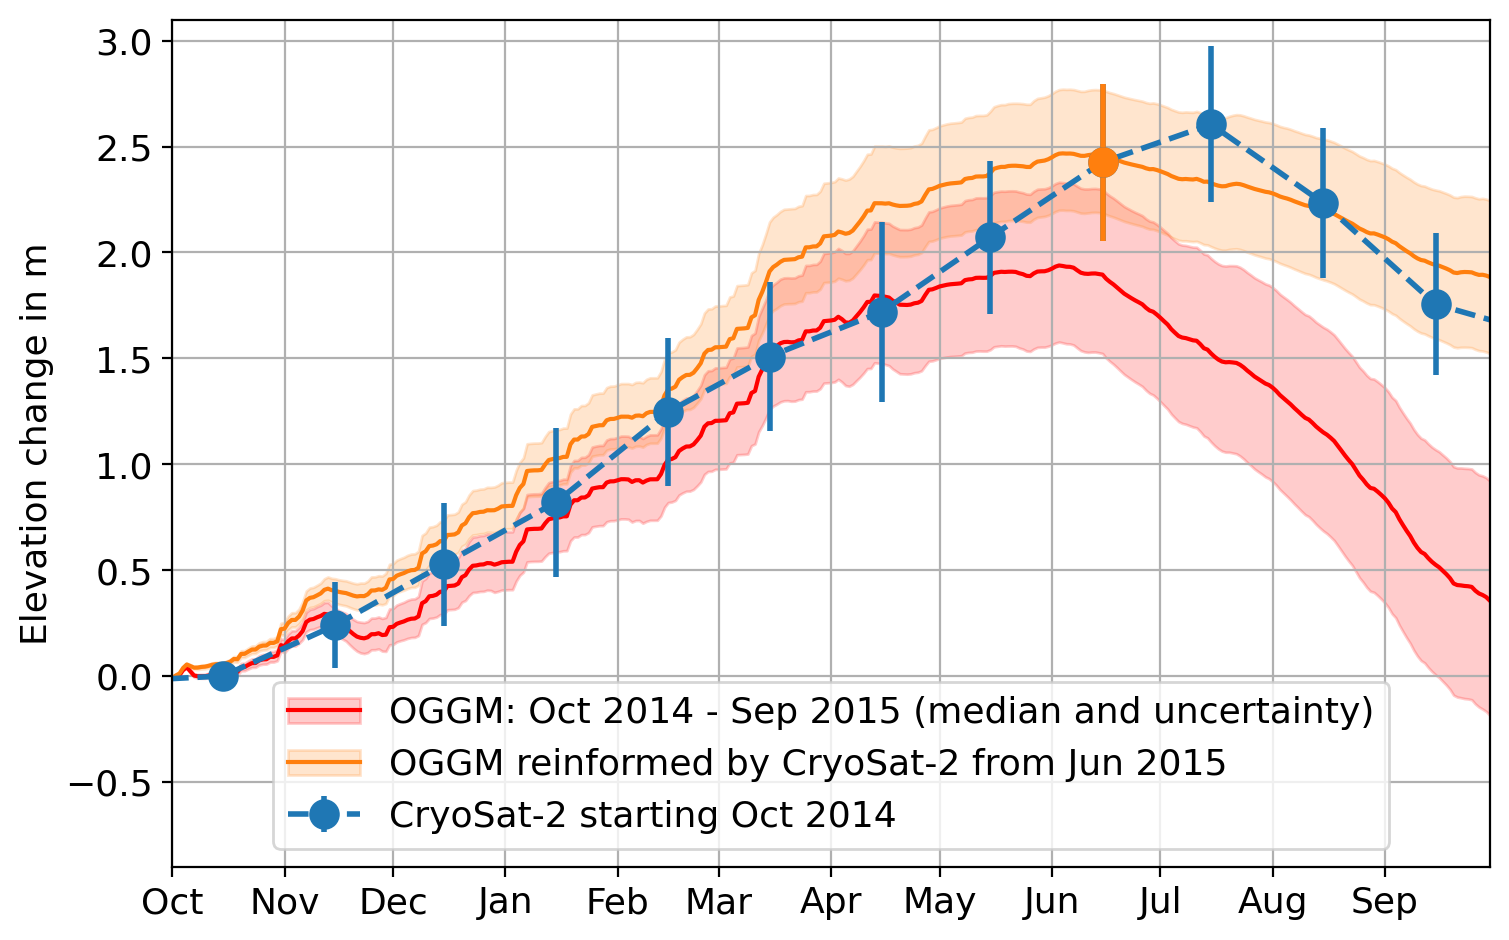

In [12]:
plot_annual_elevation_change(
    data_tree=data_tree_ice,
    L2_name=L2_name,
    L2_name_reinformed=L2_name_reinformed,
    annual_range=None,
    special_year=2015,
    add_special_year_uncertainty=True,
    add_observation=True,
    add_observation_used_for_calibration='2015-06-01',
    ylim=[-0.9, 3.1],
)

The **red line** shows the **out-of-the-box model output**, as seen in the previous plots.

The **blue line** represents **CryoSat-2 elevation change observations**. These observations confirm - and even strengthen - the signal of a **delayed onset of the melt season**. They provide new information that DTC-Glaciers can use to update its representation of the year.

The **orange line** shows the **DTC-Glaciers output after re-calibration**. In hindsight, this updated model output aligns much more closely with what actually occurred.

**By combining Earth Observation data with glacier modelling, a decision-maker in mid-summer 2015 could have had a much stronger basis for anticipating the risks ahead.**



## Stay in touch

**DTC-Glaciers** is an **ESA-funded pilot project** that develops a prototype **Glacier Digital Twin** to help anticipate and respond to hydrological changes in glacierised regions. By combining **Earth observation data** with **process-based models**, the project aims to provide **timely and reliable information** to support decision-making.

The project is currently in an **early prototype phase**. We welcome **feedback, ideas, and collaboration** from the community to help shape its future.

To learn more and get involved, visit our website: [https://dtcglaciers.org](https://dtcglaciers.org)